# Unit operation results

### A note on design and modeling

BioSTEAM includes a wide range of [unit operation](../API/units/index.txt) models and cost correlations adapted from design textbooks and literature [[1-5]](#References). Essential unit operations such as [pumps](../API/units/Pump.txt), [heat exchangers](../API/units/heat_exchange.txt), [flash vessels](../API/units/Flash.txt), and [distillation columns](../API/units/distillation.txt) are some of the most rigorously modeled and designed. Design requirements for these essential units are calculated based on design specifications such as operating temperature and pressure, feed conditions, construction material, and degree of separation. These design requirements include, but are not limited to, the heat-transfer area of heat exchangers, the size and thickness of pressure vessels, and number of stages in a distillation column. Other unit operation models are modeled as [splitters](../API/units/splitting.txt) (i.e., a specified fraction of each component entering a unit is separated), and the purchase price is estimated using size factor correlations that are ultimately a function of material flow rates. BioSTEAM chooses purchase price correlations and construction factors based on the design specifications and requirements for each unit operation. For detailed documentation and examples of each unit operation, visit the [units subpackage documentation](../API/units/index.txt).

### A good example 

In the following example, BioSTEAM's binary distillation column is used to highlight key details here on where do unit operations store results:

In [1]:
from biosteam import Stream, settings
from biosteam.units import BinaryDistillation
import biosteam as bst
bst.nbtutorial()

# First set the property package
settings.set_thermo(['Water', 'Ethanol'])

# Create the feed at the bubble point
feed = Stream('feed', Water=1.08e+03, Ethanol=586)
bp = feed.bubble_point_at_P()
feed.T = bp.T # Feed at bubble point temperature

# Create a distillation column and simulate
D1 = BinaryDistillation('D1', ins=feed,
                    outs=('distillate', 'bottoms_product'),
                    LHK=('Ethanol', 'Water'), # Light and heavy keys
                    y_top=0.79, # Light key composition at the distillate
                    x_bot=0.001, # Light key composition at the bottoms product
                    k=1.25, # Ratio of actual reflux over minimum reflux
                    is_divided=True) # Whether the rectifying and stripping sections are divided
D1.show()

BinaryDistillation: D1
ins...
[0] feed
    phase: 'l', T: 354.28 K, P: 101325 Pa
    flow (kmol/hr): Water    1.08e+03
                    Ethanol  586
outs...
[0] distillate
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] bottoms_product
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


Before simulating a distillation column, no results are available, streams are empty, and the components are initialized but empty as well:

In [2]:
D1.design_results

{}

In [3]:
D1.purchase_costs

{}

In [4]:
D1.heat_utilities

[]

In [5]:
D1.power_utility

PowerUtility:
consumption: 0 kW
production: 0 kW
power: 0 kW
cost: 0 USD/hr


All unit operations have the `design_results`, `purchase_costs`, `heat_utilities`, and `power_utility` attributes. The `heat_utilities` attribute is a list of [HeatUtility](../API/HeatUtility.txt) objects and the `power_utility` attribute is a [PowerUtility](../API/PowerUtility.txt) object. Unit operations may also have attributes and components specific to that unit operation. For example, here are few distillation-specific components:

In [6]:
D1.condenser

HXutility: Condenser
ins...
[0] s.1
    phase: 'g', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] s.2
    phases: ('g', 'l'), T: 298.15 K, P: 101325 Pa
     flow: 0


In [7]:
D1.boiler

HXutility: Boiler
ins...
[0] s.2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] s.3
    phases: ('g', 'l'), T: 298.15 K, P: 101325 Pa
     flow: 0


After simulation, the unit operation along with its components will calculate all design results, purchase costs, and utilities:

In [8]:
D1.simulate()
D1.show(T='degC', P='atm', composition=True)

BinaryDistillation: D1
ins...
[0] feed
    phase: 'l', T: 81.125 degC, P: 1 atm
    composition (%): Water    64.8
                     Ethanol  35.2
                     -------  1.67e+03 kmol/hr
outs...
[0] distillate
    phase: 'g', T: 78.484 degC, P: 1 atm
    composition (%): Water    21
                     Ethanol  79
                     -------  741 kmol/hr
[1] bottoms_product
    phase: 'l', T: 99.64 degC, P: 1 atm
    composition (%): Water    99.9
                     Ethanol  0.1
                     -------  925 kmol/hr


In [9]:
D1.design_results

{'Theoretical feed stage': 26,
 'Theoretical stages': 31,
 'Minimum reflux': 0.7708367097030262,
 'Reflux': 0.9635458871287828,
 'Rectifier stages': 45.0,
 'Stripper stages': 9.0,
 'Rectifier height': 78.940416,
 'Stripper height': 25.804416,
 'Rectifier diameter': 10.020898268926565,
 'Stripper diameter': 7.860937202956291,
 'Rectifier wall thickness': 0.5,
 'Stripper wall thickness': 0.375,
 'Rectifier weight': 42113.95986793382,
 'Stripper weight': 12203.148887354826}

In [10]:
D1.purchase_costs

{'Rectifier trays': 97416.23273970497,
 'Stripper trays': 20916.557231331746,
 'Rectifier tower': 165804.26646039748,
 'Stripper platform and ladders': 52194.73570998691,
 'Stripper tower': 74738.51598956346,
 'Rectifier platform and ladders': 18264.38468224942,
 'Condenser - Floating head': 65778.41245145121,
 'Boiler - Floating head': 65109.26213301636}

In [11]:
D1.heat_utilities

[<cooling_water: -2.84e+07 kJ/hr, 1.94e+04 kmol/hr, 9.45 USD/hr>,
 <low_pressure_steam: 6.26e+07 kJ/hr, 1.62e+03 kmol/hr, 385 USD/hr>]

In [12]:
D1.power_utility

PowerUtility:
consumption: 0 kW
production: 0 kW
power: 0 kW
cost: 0 USD/hr


The `results()` method can conviniently present all these results: 

In [13]:
print(D1.results())

Divided Distillation Column                           Units        D1
Cooling water       Duty                              kJ/hr -2.84e+07
                    Flow                            kmol/hr  1.94e+04
                    Cost                             USD/hr      9.45
Low pressure steam  Duty                              kJ/hr  6.26e+07
                    Flow                            kmol/hr  1.62e+03
                    Cost                             USD/hr       385
Design              Theoretical feed stage                         26
                    Theoretical stages                             31
                    Minimum reflux                    Ratio     0.771
                    Reflux                            Ratio     0.964
                    Rectifier stages                               45
                    Stripper stages                                 9
                    Rectifier height                     ft      78.9
                    

Note that the units for the design results are in the `_units` dictionary:

In [14]:
D1._units

{'Minimum reflux': 'Ratio',
 'Reflux': 'Ratio',
 'Rectifier height': 'ft',
 'Rectifier diameter': 'ft',
 'Rectifier wall thickness': 'in',
 'Rectifier weight': 'lb',
 'Stripper height': 'ft',
 'Stripper diameter': 'ft',
 'Stripper wall thickness': 'in',
 'Stripper weight': 'lb',
 'Height': 'ft',
 'Diameter': 'ft',
 'Wall thickness': 'in',
 'Weight': 'lb'}

It is also possible to retrieve design results in another set of units:

In [15]:
rectifier_height = D1.get_design_result('Rectifier height', 'meter')
round(rectifier_height)

24

For completeness, here are the rest of the results:

In [16]:
D1.condenser

HXutility: Condenser
ins...
[0] s.1
    phase: 'g', T: 351.72 K, P: 101325 Pa
    flow (kmol/hr): Water    329
                    Ethanol  1.13e+03
outs...
[0] s.2
    phases: ('g', 'l'), T: 351.63 K, P: 101325 Pa
    flow (kmol/hr): (g) Water    156
                        Ethanol  585
                    (l) Water    173
                        Ethanol  540


In [17]:
D1.boiler

HXutility: Boiler
ins...
[0] s.2
    phase: 'l', T: 370.63 K, P: 101325 Pa
    flow (kmol/hr): Water    2.36e+03
                    Ethanol  19.6
outs...
[0] s.3
    phases: ('g', 'l'), T: 372.79 K, P: 101325 Pa
    flow (kmol/hr): (g) Water    1.44e+03
                        Ethanol  18.7
                    (l) Water    924
                        Ethanol  0.925


Unit operations may also have special methods that you may find useful:

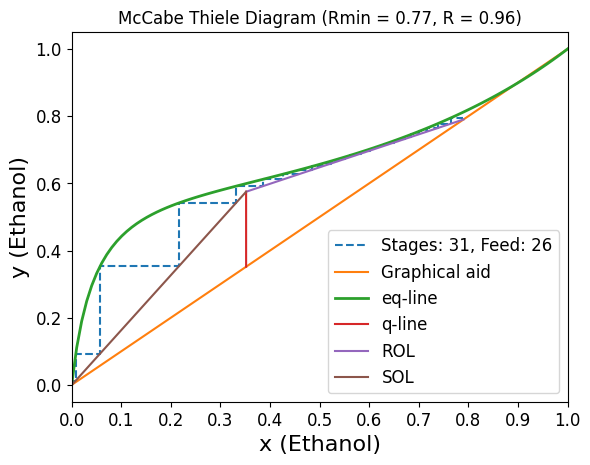

In [18]:
from matplotlib import pyplot as plt
D1.plot_stages()
plt.show()

### References

<a id='References'></a>

1. Seider, W. D.; Lewin, D. R.; Seader, J. D.; Widagdo, S.; Gani, R.; Ng, M. K. Cost Accounting and Capital Cost Estimation. In Product and Process Design Principles; Wiley, 2017; pp 426−485.
2. Svrcek, W. Y.; Monnery, W. D. Design Two-Phase Separators Within the Right Limits. In Chemical Engineering Progress (CEP); The American Institute of Chemical Engineers, 1993; pp 53−60.
3. Apostolakou, A. A.; Kookos, I. K.; Marazioti, C.; Angelopoulos, K. C. Techno-Economic Analysis of a Biodiesel Production Process from Vegetable Oils. Fuel Process. Technol. 2009, 90, 1023−1031.
4. Green, D. W. Distillation. In Perry’s Chemical Engineers’ Handbook, 9 ed.; McGraw-Hill Education, 2018.
5. Duss, M.; Taylor, R. Predict Distillation Tray Efficiency. Chem. Eng. Prog. 2018, 24−30.